In [63]:
# use venv ~opensim/bin/python

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from scipy.signal import butter, lfilter, freqz


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

def lowpass_filter(data, cutoff=10, fs=200, order=4):

    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs  # Nyquist frequency
        normal_cutoff = cutoff / nyq  # Normalize the cutoff frequency
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    # Apply the filter to each column of the data
    for i in range(data.shape[1]):
        data[:, i] = butter_lowpass_filter(data[:, i].copy(), cutoff, fs, order)
    return data
    
    



In [65]:
# get random index for IMU sensor
def sampleSensor(sensorName):
    index = random.randint(0, 49)
    return sensorName if index == 0 else sensorName + str(index)

In [66]:
def scaleDataInstance(data):
    for i in range(data.shape[1]):
        if max(abs(data[:, i])) != 0:
            data[:, i] = data[:, i] / max(abs(data[:, i]))
    return data


# take max abs value of each channel
# divide all values by max value

In [67]:
def removeZeros(data):
    return np.delete(data, [0, 16], axis=1)

In [68]:
def createIMUDataInstance(quaternion_data, velocity_data, acceleration_data, orientation_only = False):
    # Get indices for sensors to use in this data instance
    # humerus_l_imu_tag = "humerus_l_imu"
    # humerus_r_imu_tag = "humerus_r_imu"
    # ulna_l_imu_tag = "ulna_l_imu"
    # ulna_r_imu_tag = "ulna_r_imu"
    # tags = [humerus_l_imu_tag, humerus_r_imu_tag, ulna_l_imu_tag, ulna_r_imu_tag]

    humerus_r_imu_tag = "humerus_r_imu"
    ulna_r_imu_tag = "ulna_r_imu"
    tags = [humerus_r_imu_tag, ulna_r_imu_tag]

    concatenated = []
    for tag in tags:
        raw_q = quaternion_data[tag].values
        raw_v = velocity_data[tag].values
        raw_a = acceleration_data[tag].values

        if not orientation_only:
            total = np.zeros([raw_q.shape[0], 10])
            for i in range(raw_q.shape[0]):
                total[i, :4] = np.array(raw_q[i].split(',')).astype(float)
                total[i, 4:7] = np.array(raw_v[i].split(',')).astype(float)
                total[i, 7:] = np.array(raw_a[i].split(',')).astype(float)
        else:
            total = np.zeros([raw_q.shape[0], 4])
            for i in range(raw_q.shape[0]):
                total[i, :4] = np.array(raw_q[i].split(',')).astype(float)
        
        concatenated.append(total)

    concatenated_data = np.concatenate(concatenated, axis=1)
    return concatenated_data


In [90]:
def formatDataInstance(kinematics_data, quaternion_data, velocity_data, acceleration_data):

    # get imu data at time index
    new_IMU_instance = createIMUDataInstance(quaternion_data, velocity_data, acceleration_data, orientation_only=False)[1:]
    # right_arm_kinematics = kinematics_data.values[:, 26:31]
    # left_arm_kinematics = kinematics_data.values[:, 33:38]
    # right_leg_kinematics = kinematics_data.values[:, 7:13]
    # left_leg_kinematics = kinematics_data.values[:, 15:21]
    # torso_kinematics = np.concatenate([kinematics_data.values[:, 1:7],  kinematics_data.values[:, 23:26]], axis=1)
    # new_kinematics_instance = np.concatenate([left_arm_kinematics, 
    #                                           right_arm_kinematics,
    #                                         #   left_leg_kinematics,
    #                                         #   right_leg_kinematics,
    #                                           torso_kinematics], axis = 1)
    print(kinematics_data.shape)
    right_arm_torso_kinematics = kinematics_data[:49999].values[:, 23:32]
    new_kinematics_instance = np.concatenate([right_arm_torso_kinematics], axis=1)

    print("Kinematics Dimensions: ", new_kinematics_instance.shape)
    print("IMU Dimensions: ", new_IMU_instance.shape)
    # concatenate and return
    new_data_instance = np.concatenate([new_kinematics_instance, new_IMU_instance], axis=1)
    print("Concatenated Dimensions: ", new_data_instance.shape)
    return new_data_instance

In [91]:
def augment_temporal_minus_one(data):
    r = data.shape[0]
    c = data.shape[1]

    res = np.zeros((r-1, c*2))
    for j in range(c):
        res[:, j*2] = data[1:, j]
        res[:, j*2+1] = data[0:r-1, j]
    
    return res

In [92]:
def augment_temporal_plus_one(data):
    r = data.shape[0]
    c = data.shape[1]

    res = np.zeros((r-1, c*2))
    for j in range(c):
        res[:, j*2] = data[0:r-1, j]
        res[:, j*2+1] = data[1:, j]
    return res

In [93]:
def mask(data):
    r = data.shape[0]
    c = data.shape[1]
    res = np.copy(data)

    for j in range(0, 38, 2):
        res[:, j] = -2
    return np.vstack((data, res))

In [98]:
def createDataset(trial_num, trial_type, label, smooth=False, scale=False, augment_temporal=False, mask=False):

    # filepath = "/home/franklin/Research"
    # Local: /Users/FranklinZhao/Research
    # SSH: /home/franklin/Research



    # load IMU data, non-filtered
    # quaternion_path = f"{filepath}/Dataset/vIMU/Experimental/{trial_type}_{trial_num}/Rajapogal_FullBody_calibrated_orientations.sto"
    # velocity_path = f"{filepath}/Dataset/vIMU/Experimental/{trial_type}_{trial_num}/Rajapogal_FullBody_calibrated_angular_velocity.sto"
    # acceleration_path = f"{filepath}/Dataset/vIMU/Experimental/{trial_type}_{trial_num}/Rajapogal_FullBody_calibrated_linear_accelerations.sto"

    # load IMU data, filtered
    # quaternion_path = f"{filepath}/Dataset/vIMU/Experimental/{trial_type}_{trial_num}/filtered_6hz_orientations.sto"
    # velocity_path = f"{filepath}/Dataset/vIMU/Experimental/{trial_type}_{trial_num}/filtered_6hz_angular_velocity.sto"
    # acceleration_path = f"{filepath}/Dataset/vIMU/Experimental/{trial_type}_{trial_num}/filtered_6hz_linear_accelerations.sto"

    # quaternion_path = "/home/franklin/Research/Dataset/vIMU/Experimental/expdata/expdata_orientations.sto"
    # velocity_path = "/home/franklin/Research/Dataset/vIMU/Experimental/expdata/expdata_angular_velocity.sto"
    # acceleration_path = "/home/franklin/Research/Dataset/vIMU/Experimental/expdata/expdata_linear_accelerations.sto"

    quaternion_path = "/home/franklin/Research/Dataset/vIMU/Augmented/synthdata/synthdata_orientations.sto"
    velocity_path = "/home/franklin/Research/Dataset/vIMU/Augmented/synthdata/synthdata_angular_velocity.sto"
    acceleration_path = "/home/franklin/Research/Dataset/vIMU/Augmented/synthdata/synthdata_linear_accelerations.sto"
    # read IMU data into dataframes
    quaternion_data = pd.read_csv(filepath_or_buffer=quaternion_path, sep='\t', header=4)
    velocity_data = pd.read_csv(filepath_or_buffer=velocity_path, sep='\t', header=4)
    acceleration_data = pd.read_csv(filepath_or_buffer=acceleration_path, sep='\t', header=4)

    # load kinematics data
    # kinematics_path = f"{filepath}/Dataset/Motion/Experimental/{trial_type}_0{trial_num}.mot"
    # kinematics_path = "/home/franklin/Research/Dataset/Motion/Experimental/expdata.mot"
    kinematics_path = "/home/franklin/Research/Dataset/Motion/Augmented/syndata.mot"

    # read kinematics data into dataframes
    kinematics_data = pd.read_csv(filepath_or_buffer=kinematics_path, header=8, skipinitialspace=True, sep='\t')    
    # create data instance
    new_data_instance = formatDataInstance(kinematics_data, quaternion_data, velocity_data, acceleration_data)
    # smooth data
    if smooth:
        print("smoothing")
        new_data_instance = lowpass_filter(new_data_instance, cutoff=6)
    # scale data instance
    if scale:
        print("scaling")
        new_data_instance = scaleDataInstance(new_data_instance)
    # augment temporal
    if augment_temporal:
        print("augmenting temporal")
        new_data_instance = augment_temporal_minus_one(new_data_instance)
    # mask
    if mask:
        print("masking")
        new_data_instance = mask(new_data_instance)
    print(new_data_instance.shape)

    # save data instance
    df = pd.DataFrame(new_data_instance)
    # if label:
    #     file_path = f'{filepath}/data_instance_{trial_num}_{label}.csv'
    # else:
    #     file_path = f'{filepath}/data_instance_{trial_num}.csv'
    file_path = "/home/franklin/Research/synthdata.csv"
    df.to_csv(file_path, index=False, header=False)
    print("saved!")

In [99]:
# # trial data
# trial_type = "tug"
# for i in range(1, 4):
#     print(f"Creating Dataset {i}")
#     createDataset(i, trial_type, label='smooth', smooth = True, scale = True)

createDataset(0, "", label="", smooth=True, scale=True)

(50000, 3)
(107999, 41)
Kinematics Dimensions:  (49999, 9)
IMU Dimensions:  (49999, 20)
Concatenated Dimensions:  (49999, 29)
smoothing
scaling
(49999, 29)
saved!


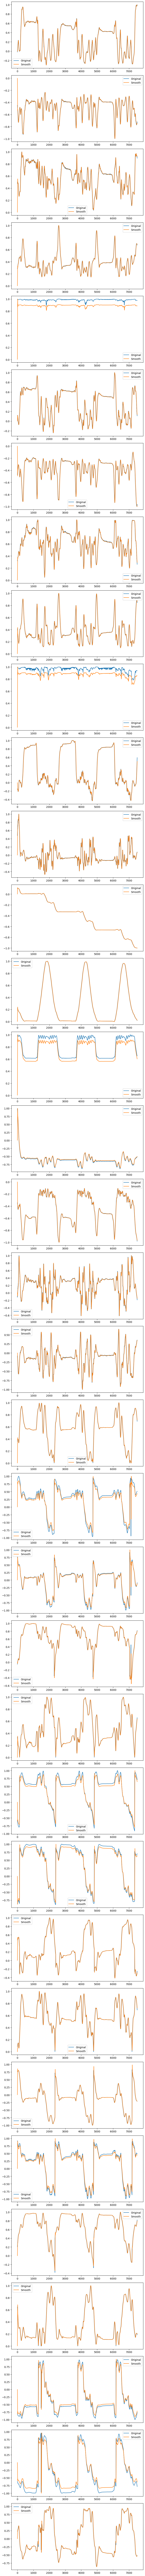

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_csv_columns_dual(file_path1, file_path2):
    """
    Reads two CSV files and plots each corresponding column in the same subplot.

    Parameters:
        file_path1 (str): Path to the first CSV file.
        file_path2 (str): Path to the second CSV file.
    """
    # Read CSV files
    df1 = pd.read_csv(file_path1)#.iloc[:200, :]
    df2 = pd.read_csv(file_path2)#.iloc[:200, :]
    
    # Determine the number of columns
    num_columns = len(df1.columns)
    
    # Create a figure and subplots
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, 4 * num_columns))
    
    # Ensure axes is iterable (for single-column cases)
    if num_columns == 1:
        axes = [axes]
    
    # Plot each column from both files on the same subplot
    for i in range(num_columns):
        axes[i].plot(df1.index, df1.iloc[:, i], label=f'Original')
        axes[i].plot(df2.index, df2.iloc[:, i], label=f'Smooth')
        axes[i].legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage
plot_csv_columns_dual("/home/franklin/Research/data_instance_1.csv", "/home/franklin/Research/data_instance_1_smooth.csv")
